In [1]:
from helper import *

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cpu


In [2]:
# Neural Networks

# RGB to HSV Network
class RGBtoHSVNet(nn.Module):
    def __init__(self):
        super(RGBtoHSVNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Iris Network
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# MNIST Network
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# RGB-HSV Dataset
rgb_train = generate_rgb_samples(1000, device=device, seed=42)
hsv_train = rgb_to_hsv(rgb_train)

rgb_test = generate_rgb_samples(250, device=device, seed=123)
hsv_test = rgb_to_hsv(rgb_test)

rgb_train_loader = DataLoader(TensorDataset(rgb_train.cpu(), hsv_train.cpu()), batch_size=32, shuffle=False)
rgb_test_loader = DataLoader(TensorDataset(rgb_test.cpu(), hsv_test.cpu()), batch_size=32, shuffle=False)

# Show specific samples:
# show_rgb_hsv_samples(rgb_train.cpu(), hsv_train.cpu(), indices=[0, 10, 50])
# show_rgb_hsv_samples(rgb_train.cpu(), hsv_train.cpu(), indices=25)  # Single index

# Example usage (deterministic training):
rgb_model = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(rgb_model.parameters(), lr=0.001)
rgb_losses, trained_rgb = train_model(rgb_model, rgb_train_loader, rgb_criterion, rgb_optimizer, num_epochs=100, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cpu
Epoch [20/100], Loss: 0.006379
Epoch [40/100], Loss: 0.003748
Epoch [60/100], Loss: 0.002776
Epoch [80/100], Loss: 0.002297
Epoch [100/100], Loss: 0.001980


In [4]:
# Iris Dataset
iris = sklearn_datasets.load_iris()
X_iris = torch.FloatTensor(iris.data)
y_iris = torch.LongTensor(iris.target)

# Shuffle the dataset before splitting (deterministic with seed)
np.random.seed(42)
indices = np.random.permutation(len(X_iris))
X_iris_shuffled = X_iris[indices]
y_iris_shuffled = y_iris[indices]

# Split into train/test
split = int(0.8 * len(X_iris_shuffled))
X_iris_train, X_iris_test = X_iris_shuffled[:split], X_iris_shuffled[split:]
y_iris_train, y_iris_test = y_iris_shuffled[:split], y_iris_shuffled[split:]

iris_train_loader = DataLoader(TensorDataset(X_iris_train, y_iris_train), batch_size=16, shuffle=False)
iris_test_loader = DataLoader(TensorDataset(X_iris_test, y_iris_test), batch_size=16, shuffle=False)

# Show specific samples:
# show_iris_samples(X_iris_shuffled, y_iris_shuffled, indices=[0, 50, 100])


# Example usage (deterministic training):
iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.01)
iris_losses, trained_iris = train_model(iris_model, iris_train_loader, iris_criterion, iris_optimizer, num_epochs=50, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cpu
Epoch [20/50], Loss: 0.145568
Epoch [40/50], Loss: 0.107952


In [5]:
# MNIST Dataset (deterministic)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create datasets with fixed generator for reproducibility
g = torch.Generator()
g.manual_seed(42)

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False, generator=g)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Example usage (deterministic training):
mnist_model = MNISTNet()
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.SGD(mnist_model.parameters(), lr=0.01)
mnist_losses, trained_mnist = train_model(mnist_model, mnist_train_loader, mnist_criterion, mnist_optimizer, num_epochs=5, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cpu


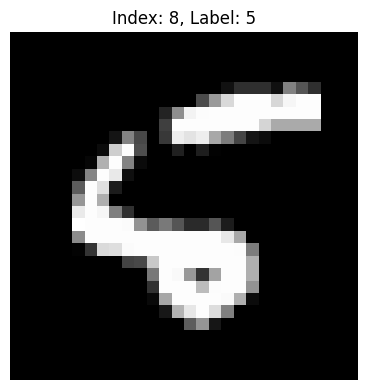

In [6]:
# Show specific samples:
show_mnist_samples(mnist_test_loader, indices=8)  # Single index

In [7]:
# RGB
predictions_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=42)  # Single index

# Iris
predictions_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris, iris_test_loader, dataset_type='iris', indices=15)  # Single index

# MNIST
predictions_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(trained_mnist, mnist_test_loader, dataset_type='mnist', indices=8)  # Single index

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
42     (0.720, 0.696, 0.640) (0.116, 0.112, 0.720) (0.231, 0.097, 0.723)
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
15     versicolor   versicolor   0.9960      
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
8      5      6      0.9870      


In [8]:
# Example usage of get_activations function

print("=== RGB-HSV Network Activations ===")
# Get activations for entire training dataset
rgb_inputs, rgb_activations, rgb_outputs = get_activations(trained_rgb, rgb_train_loader, dataset_type='rgb_hsv')
print(f"Full dataset - Inputs shape: {rgb_inputs.shape}")
print(f"Full dataset - Activations shape: {rgb_activations.shape}")
print(f"Full dataset - Outputs shape: {rgb_outputs.shape}")

print("\n=== Iris Network Activations ===")
# Get activations for entire training dataset
iris_inputs, iris_activations, iris_outputs = get_activations(trained_iris, iris_train_loader, dataset_type='iris')
print(f"Full dataset - Inputs shape: {iris_inputs.shape}")
print(f"Full dataset - Activations shape: {iris_activations.shape}")
print(f"Full dataset - Outputs shape: {iris_outputs.shape}")

print("\n=== MNIST Network Activations ===")
# Get activations for entire training dataset (this might be large!)
mnist_inputs, mnist_activations, mnist_outputs = get_activations(trained_mnist, mnist_train_loader, dataset_type='mnist')
print(f"Full dataset - Inputs shape: {mnist_inputs.shape}")
print(f"Full dataset - Activations shape: {mnist_activations.shape}")
print(f"Full dataset - Outputs shape: {mnist_outputs.shape}")

=== RGB-HSV Network Activations ===
Full dataset - Inputs shape: torch.Size([1000, 3])
Full dataset - Activations shape: torch.Size([1000, 256])
Full dataset - Outputs shape: torch.Size([1000, 3])

=== Iris Network Activations ===
Full dataset - Inputs shape: torch.Size([120, 4])
Full dataset - Activations shape: torch.Size([120, 384])
Full dataset - Outputs shape: torch.Size([120, 3])

=== MNIST Network Activations ===
Full dataset - Inputs shape: torch.Size([60000, 784])
Full dataset - Activations shape: torch.Size([60000, 384])
Full dataset - Outputs shape: torch.Size([60000, 10])


RGB-HSV
Single sample - Inputs shape: torch.Size([1, 3])
Single sample - Activations shape: torch.Size([1, 256])
Single sample - Outputs shape: torch.Size([1, 3])
Iris
Single sample - Inputs shape: torch.Size([1, 4])
Single sample - Activations shape: torch.Size([1, 384])
Single sample - Outputs shape: torch.Size([1, 3])
MNIST
Single sample - Inputs shape: torch.Size([1, 784])
Single sample - Activations shape: torch.Size([1, 384])
Single sample - Outputs shape: torch.Size([1, 10])


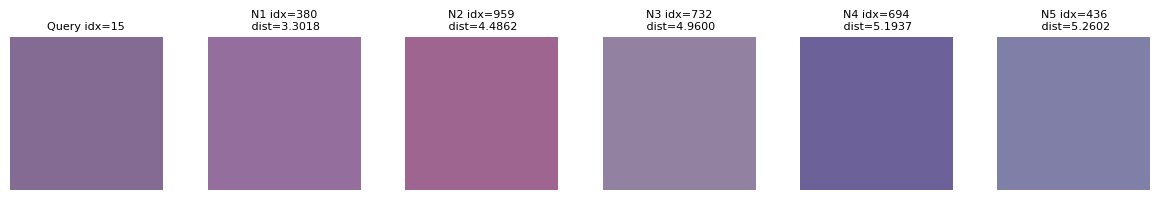

Iris K-NN Showcase (Query from test set, neighbors from train set)
-------------------------------------------------------------------------------------------
Role     Index  Class        Distance   sepal_length sepal_width  petal_length petal_width 
-------------------------------------------------------------------------------------------
Query    15     versicolor              6.90         3.10         4.90         1.50        
-------------------------------------------------------------------------------------------
Neighbor 42     versicolor   12.6966    6.70         3.10         4.70         1.50        
Neighbor 4      versicolor   13.8801    6.80         2.80         4.80         1.40        
Neighbor 110    versicolor   23.8528    6.50         2.80         4.60         1.50        
Neighbor 112    versicolor   25.9883    7.00         3.20         4.70         1.40        
Neighbor 48     versicolor   29.5538    6.60         3.00         4.40         1.40        
-------------

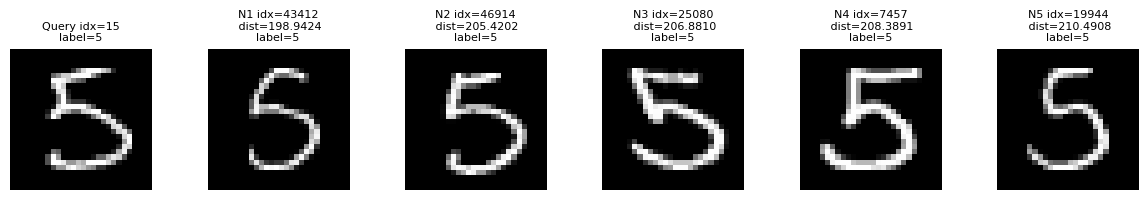

In [9]:
sample_index = 15
k_neighbors = 5

# Get activations for single sample
single_rgb_inputs, single_rgb_activations, single_rgb_outputs = get_activations(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=sample_index)
print("RGB-HSV")
print(f"Single sample - Inputs shape: {single_rgb_inputs.shape}")
print(f"Single sample - Activations shape: {single_rgb_activations.shape}")
print(f"Single sample - Outputs shape: {single_rgb_outputs.shape}")

# Get activations for single sample
single_iris_inputs, single_iris_activations, single_iris_outputs = get_activations(trained_iris, iris_test_loader, dataset_type='iris', indices=sample_index)
print("Iris")
print(f"Single sample - Inputs shape: {single_iris_inputs.shape}")
print(f"Single sample - Activations shape: {single_iris_activations.shape}")
print(f"Single sample - Outputs shape: {single_iris_outputs.shape}")

# Get activations for single sample
single_mnist_inputs, single_mnist_activations, single_mnist_outputs = get_activations(trained_mnist, mnist_test_loader, dataset_type='mnist', indices=sample_index)
print("MNIST")
print(f"Single sample - Inputs shape: {single_mnist_inputs.shape}")
print(f"Single sample - Activations shape: {single_mnist_activations.shape}")
print(f"Single sample - Outputs shape: {single_mnist_outputs.shape}")

# 1. Using RGB activations with L1 distance
indices_rgb, distances_rgb = find_knn(rgb_activations, single_rgb_activations, k=k_neighbors, metric='l1')

# 2. Using Iris inputs with Cosine distance
indices_iris, distances_iris = find_knn(iris_activations, single_iris_activations, k=k_neighbors, metric='l1')

# 3. Using MNIST outputs with L1 distance
indices_mnist, distances_mnist = find_knn(mnist_activations, single_mnist_activations, k=k_neighbors, metric='l1')

showcase_rgb_neighbors(rgb_train.cpu(), knn_indices=indices_rgb, knn_distances=distances_rgb, rgb_test=rgb_test.cpu(), query_index=sample_index, n_cols=k_neighbors+1, square_size=120)

showcase_iris_neighbors(X_iris_train, y_iris_train, indices_iris, knn_distances=distances_iris, X_test=X_iris_test, y_test=y_iris_test, query_index=sample_index)

showcase_mnist_neighbors(mnist_train_loader, knn_indices=indices_mnist, knn_distances=distances_mnist, test_dataloader=mnist_test_loader, query_index=sample_index, n_cols=k_neighbors+1, cmap='gray')